In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from torchvision.models import convnext_base
from torch import optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.segmentation import slic
import torch.nn.functional as F

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-03-19 13:57:12.841357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742372832.902662    6625 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742372832.923470    6625 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742372833.045305    6625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742372833.045333    6625 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742372833.045335    6625 computation_placer.cc:177] computation placer alr

Using device: cuda


In [2]:
# Data Generator Setup
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagenerator = ImageDataGenerator(rescale=1./255)

train_data = train_datagenerator.flow_from_directory(
    '/home/chemicalmyth/Cotton_Dataset/train',
    target_size=(224, 224),
    batch_size=32,  # Reduced batch size to avoid GPU memory issues
    class_mode='categorical'
)

test_data = test_datagenerator.flow_from_directory(
    '/home/chemicalmyth/Cotton_Dataset/val',
    target_size=(224, 224),
    batch_size=32,  # Reduced batch size
    class_mode='categorical'
)

Found 1359 images belonging to 4 classes.
Found 341 images belonging to 4 classes.


In [3]:
def generate_superpixels(image):
    """Generates superpixels from an image."""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    if image.max() > 1.0:
        image = image / 255.0
    
    segments = slic(image, n_segments=100, compactness=10, sigma=1)
    return segments

def calculate_features(image, segments):
    """Calculates features for each superpixel."""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    num_superpixels = len(np.unique(segments))
    features = []
    
    for i in range(num_superpixels):
        mask = segments == i
        if mask.sum() > 0:
            avg_color = np.mean(image[mask], axis=0)
            features.append(avg_color)
        else:
            features.append(np.zeros(3))
    
    return np.array(features)

def create_graph_from_superpixels_pyg(image, segments, max_segments=100):
    """Creates a PyTorch Geometric graph from superpixels."""
    if len(unique_labels := np.unique(segments)) > max_segments:
        from skimage.segmentation import join_segmentations
        segments = (join_segmentations(segments, np.zeros_like(segments)) % max_segments)
    
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Calculate features
    features = np.zeros((max_segments, 3))
    for i in range(max_segments):
        mask = segments == i
        if mask.sum() > 0:
            features[i] = np.mean(image[mask], axis=0)
    
    # Create edges
    edges = set()
    height, width = segments.shape
    for i in range(height):
        for j in range(width):
            current_label = segments[i, j]
            for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_label = segments[ni, nj]
                    if current_label != neighbor_label:
                        edges.add((int(current_label), int(neighbor_label)))
    
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    if edge_index.numel() == 0:
        edge_index = torch.arange(max_segments).repeat(2, 1)
    
    node_features = torch.tensor(features, dtype=torch.float)
    return Data(x=node_features, edge_index=edge_index)

In [4]:
class ConvNeXtGCNModel(nn.Module):
    def __init__(self, num_classes=4, hidden_dim=128, max_segments=100):
        super().__init__()
        self.max_segments = max_segments
        
        # ConvNeXt backbone
        self.convnext = convnext_base(pretrained=True)
        self.convnext = nn.Sequential(*list(self.convnext.children())[:-1])
        
        # Feature processing
        self.dim_reduction = nn.Linear(1024, hidden_dim)
        
        # GCN layers
        self.gcn1 = GCNConv(hidden_dim + 3, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, images, graph_data):
        batch_size = images.size(0)
        
        # Process images through ConvNeXt
        if images.size(1) != 3:
            images = images.permute(0, 3, 1, 2)
        x = self.convnext(images)
        x = x.view(batch_size, -1)
        x = self.dim_reduction(x)
        
        # Expand CNN features
        x = x.unsqueeze(1).expand(-1, self.max_segments, -1)
        x = x.reshape(-1, x.size(-1))
        
        # Combine with graph features
        graph_x = torch.cat([graph_data.x, x], dim=1)
        
        # GCN processing
        x = self.gcn1(graph_x, graph_data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gcn2(x, graph_data.edge_index)
        x = F.relu(x)
        
        # Reshape and pool
        x = x.view(batch_size, self.max_segments, -1)
        x = torch.mean(x, dim=1)
        
        # Classification
        x = self.classifier(x)
        return x

In [5]:
def train_model(model, train_data, optimizer, criterion, device, num_epochs=10, chunk_size=4):
    model = model.to(device)
    model.train()
    
    # Calculate total number of batches per epoch
    total_images = train_data.samples
    batch_size = train_data.batch_size
    total_batches = (total_images + batch_size - 1) // batch_size
    
    print(f"Total images: {total_images}")
    print(f"Batch size: {batch_size}")
    print(f"Expected batches per epoch: {total_batches}")
    
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch {epoch + 1}/{num_epochs}")
        running_loss = 0.0
        correct = 0
        total = 0
        processed_batches = 0
        
        for batch_idx, (images, labels) in enumerate(train_data):
            
            try:

                if processed_batches >= total_batches:
                    break
                # Convert numpy arrays to tensors and handle data types
                images = torch.from_numpy(images).float().to(device)
                
                # Convert one-hot encoded labels to class indices
                if len(labels.shape) > 1:  # If labels are one-hot encoded
                    labels = np.argmax(labels, axis=1)
                labels = torch.from_numpy(labels).long().to(device)
                
                # Process images in chunks to avoid memory issues
                batch_size = images.size(0)
                all_outputs = []
                
                for i in range(0, batch_size, chunk_size):
                    chunk_images = images[i:i+chunk_size]
                    chunk_labels = labels[i:i+chunk_size]
                    
                    # Generate graphs for the chunk
                    graphs = []
                    for img in chunk_images:
                        segments = generate_superpixels(img.cpu())
                        graph_data = create_graph_from_superpixels_pyg(img.cpu(), segments)
                        graphs.append(graph_data)
                    
                    chunk_graph = Batch.from_data_list(graphs).to(device)
                    
                    # Forward pass for the chunk
                    optimizer.zero_grad()
                    outputs = model(chunk_images, chunk_graph)
                    all_outputs.append(outputs)
                    
                    # Calculate loss for the chunk
                    loss = criterion(outputs, chunk_labels)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    
                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total += chunk_labels.size(0)
                    correct += (predicted == chunk_labels).sum().item()
                
                processed_batches += 1
                
                # Print progress
                if processed_batches % 5 == 0:  # Print every 5 batches
                    print(f'[Epoch {epoch + 1}, Batch {processed_batches}/{total_batches}] '
                          f'Loss: {running_loss / 5:.3f}, '
                          f'Accuracy: {100 * correct / total:.1f}%')
                    running_loss = 0.0
                
                # Clear memory after each batch
                torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error in batch {processed_batches}: {str(e)}")
                continue
        
        epoch_accuracy = 100 * correct / total
        print(f'\nEpoch {epoch + 1} completed:')
        print(f'Total batches processed: {processed_batches}/{total_batches}')
        print(f'Final Accuracy: {epoch_accuracy:.1f}%')
        
        # Clear memory after each epoch
        torch.cuda.empty_cache()

In [6]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:

criterion = nn.CrossEntropyLoss()

# Initialize model with correct number of classes
num_classes = len(train_data.class_indices)
print(f"Number of classes: {num_classes}")

model = ConvNeXtGCNModel(num_classes=num_classes, hidden_dim=128, max_segments=100)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# # Train the model
# train_model(model, train_data, optimizer, criterion, device)

Number of classes: 4


/home/chemicalmyth/GCN_ConvNeXt/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chemicalmyth/GCN_ConvNeXt/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch
import torch.nn as nn
from torch_geometric.nn.conv import GCNConv
from torchvision.models import convnext_base

# Define your model class
class ConvNeXtGCNModel(nn.Module):
    # Same implementation as above
    pass

# Add the class to safe globals
torch.serialization.add_safe_globals([ConvNeXtGCNModel])

# Now load the model
model = torch.load('/home/chemicalmyth/GCN_ConvNeXt/convnext_gcn_model_full.pth')

# Set the model to evaluation mode
model.eval()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.Sequential was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Sequential])` or the `torch.serialization.safe_globals([Sequential])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [9]:
model.eval()

ConvNeXtGCNModel(
  (convnext): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): Lay

In [10]:
def predict_image(model, image_path, device):
    """
    Predict the class of an image using the trained model.
    
    Args:
        model: The trained ConvNeXtGCN model
        image_path: Path to the image file
        device: The device to run the model on (CPU/GPU)
    
    Returns:
        prediction: The predicted class index
        confidence: The confidence score
        probabilities: The probability distribution over classes
    """
    # Load and preprocess the image
    from PIL import Image
    import torchvision.transforms as transforms
    
    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Generate graph data
    segments = generate_superpixels(input_image[0].cpu())
    graph_data = create_graph_from_superpixels_pyg(input_image[0].cpu(), segments)
    graph_data = graph_data.to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_image, graph_data)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)
        
    return prediction.item(), confidence.item(), probabilities[0].cpu().numpy()

# Example usage:
# prediction, confidence, probabilities = predict_image(model, 'path/to/your/image.jpg', device)
# print(f"Predicted class: {prediction}")
# print(f"Confidence: {confidence:.2%}")

In [ ]:
disease_parameters = {
    healthy_cotton = {
    'strength_percentage': 28.0,  # Midpoint of 26-30 g/tex (Indian range)
    'length': 30.0,               # Midpoint of 28-32 mm (Indian range)
    'maturity_ratio': 0.9,        # Midpoint of 0.85-0.95 (Indian range)
    'elongation': 7.0,            # Midpoint of 6-8% (Indian range)
    'uniformity': 81.5,           # Midpoint of 80-83% (Indian range)
    'micronaire_index': 4.15,     # Midpoint of 3.8-4.5 (Indian range)
    'pressley_resistance': 8.0,   # Midpoint of 7.5-8.5 (Indian range)
    'trash': 2.5,                 # Midpoint of 2-3% (Indian range)
    'production': 0,              # Not specified, set to 0
    'fiber_percentage': 37.0,     # Midpoint of 36-38% (Indian range)
    'ginning_percentage': 35.0,   # Midpoint of 34-36% (Indian range)
    'colour_grade': 'White',      # Typical Indian cotton grade
    'wt_of_100_seeds': 10.0,      # Midpoint of 9-11 g (Indian range)
    'weight_of_1_boll': 5.5,      # Midpoint of 5-6 g (Indian range)
    'bolls_per_plant': 30.0,      # Midpoint of 25-35 (Indian range)
    'uhml': 30.0,                 # Midpoint of 28-32 mm (Indian range)
    'description': 'Healthy cotton plant with typical Indian cotton characteristics.'
}
    },

    fiber_parameters = {
    'fusarium_wilt': {
        'strength_percentage': -0.78,  # Average of 0.0, -0.38, -1.95
        'length': 0,                   # No values provided, set to 0
        'maturity_ratio': 0,           # No values provided, set to 0
        'elongation': -0.53,           # Average of -0.23, 0.24, -1.6
        'uniformity': -1.36,           # Average of -0.23, 0.24, -1.6
        'micronaire_index': -1.36,     # Average of 0.0, 0.0, -4.08
        'pressley_resistance': 0.16,   # Average of 0.93, -0.92, 0.47
        'trash': -0,               # Average of 5, -28.0, -50.0
        'production': -27.36,           # Average of -4.17, -28.0, -50.0
        'fiber_percentage': 0.43,      # Average of 1.26, 0.5, -0.47
        'ginning_percentage': 0,       # No values provided, set to 0
        'colour_grade': 0,             # No values provided, set to 0
        'wt_of_100_seeds': -2.72,      # Average of -1.87, -3.51, -2.78
        'weight_of_1_boll': -4.30,     # Average of -1.72, -4.62, -6.56
        'bolls_per_plant': 0,          # No values provided, set to 0
        'description': 'Fusarium wilt in cotton, showing significant reductions in fiber quality and production.'
    },
    'cotton_leaf_curl_disease': {
        'strength_percentage': -10.0,
        'length': -3.44,
        'maturity_ratio': 0,
        'elongation': -10.0,
        'uniformity': 0,
        'micronaire_index': 0,
        'pressley_resistance': 0,
        'trash': 0,
        'production': -64.5,
        'fiber_percentage': 0,
        'ginning_percentage': -3.93,
        'colour_grade': 0,
        'wt_of_100_seeds': -17.0,
        'weight_of_1_boll': -33.8,
        'bolls_per_plant': -73.5,
        'description': 'Cotton Leaf Curl Disease, causing severe damage to cotton productivity.'
    },
    'bacterial_blight': {
        'strength_percentage': -20.0,
        'length': -10.0,  # Assuming -10mm is converted to -10.0
        'maturity_ratio': 0,
        'elongation': 0,
        'uniformity': -10.0,
        'micronaire_index': -5.0,
        'pressley_resistance': 0,
        'trash': 5.0,
        'production': -20.0,
        'fiber_percentage': -8.0,
        'ginning_percentage': -7.0,
        'colour_grade': 0,
        'wt_of_100_seeds': -4.0,  # Assuming -4g is converted to -4.0
        'weight_of_1_boll': -3.0,  # Assuming -3g is converted to -3.0
        'bolls_per_plant': -20.0,
        'description': 'Bacterial Blight, causing significant reductions in fiber quality and yield.'
    
    },
#     'verticillium_wilt = {
#     'strength_percentage': 0,  # Not provided in the data, set to 0
#     'length': 29.63,          # Average of 2.5% fiber length across all degrees and cultivars
#     'maturity_ratio': 0.86,   # Average of maturity ratio across all degrees and cultivars
#     'uniformity': 48.38,      # Average of uniformity across all degrees and cultivars
#     'micronaire_index': 3.38, # Average of micronaire across all degrees and cultivars
#     'pressley_resistance': 0, # Not provided in the data, set to 0
#     'trash': 52.45,           # Average of trash across all degrees and cultivars
#     'production': 0,          # Not provided in the data, set to 0
#     'fiber_percentage': 0,    # Not provided in the data, set to 0
#     'ginning_percentage': 0,  # Not provided in the data, set to 0
#     'colour_grade': 0,        # Not provided in the data, set to 0
#     'wt_of_100_seeds': 0,     # Not provided in the data, set to 0
#     'weight_of_1_boll': 0,    # Not provided in the data, set to 0
#     'bolls_per_plant': 0,     # Not provided in the data, set to 0
#     'description': 'Verticillium Wilt, causing significant deterioration in fiber quality, particularly in micronaire, maturity, and trash content.'
# }
  }

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (560057192.py, line 2)

In [23]:
disease_parameters = {
    'healthy_cotton': {
        'strength_percentage': 28.0,  # Midpoint of 26-30 g/tex (Indian range)
        'length': 30.0,               # Midpoint of 28-32 mm (Indian range)
        'maturity_ratio': 0.9,        # Midpoint of 0.85-0.95 (Indian range)
        'elongation': 7.0,           # Midpoint of 6-8% (Indian range)
        'uniformity': 81.5,           # Midpoint of 80-83% (Indian range)
        'micronaire_index': 4.15,     # Midpoint of 3.8-4.5 (Indian range)
        'pressley_resistance': 8.0,  # Midpoint of 7.5-8.5 (Indian range)
        'trash': 2.5,                 # Midpoint of 2-3% (Indian range)
        'production': 0,              # Not specified, set to 0
        'fiber_percentage': 37.0,     # Midpoint of 36-38% (Indian range)
        'ginning_percentage': 35.0,   # Midpoint of 34-36% (Indian range)
        'colour_grade': 'White',      # Typical Indian cotton grade
        'wt_of_100_seeds': 10.0,      # Midpoint of 9-11 g (Indian range)
        'weight_of_1_boll': 5.5,      # Midpoint of 5-6 g (Indian range)
        'bolls_per_plant': 30.0,      # Midpoint of 25-35 (Indian range)
        'uhml': 30.0,                 # Midpoint of 28-32 mm (Indian range)
        'description': 'Healthy cotton plant with typical Indian cotton characteristics.'
    },
    'fiber_parameters': {
        'bacterial_blight': {
            'strength_percentage': -20.0,
            'length': -10.0,  # Assuming -10mm is converted to -10.0
            'maturity_ratio': 0,
            'elongation': 0,
            'uniformity': -10.0,
            'micronaire_index': -5.0,
            'pressley_resistance': 0,
            'trash': 5.0,
            'production': -20.0,
            'fiber_percentage': -8.0,
            'ginning_percentage': -7.0,
            'colour_grade': 0,
            'wt_of_100_seeds': -4.0,  # Assuming -4g is converted to -4.0
            'weight_of_1_boll': -3.0,  # Assuming -3g is converted to -3.0
            'bolls_per_plant': -20.0,
            'description': 'Bacterial Blight, causing significant reductions in fiber quality and yield.'
        },
        'curl_virus': {
            'strength_percentage': -10.0,
            'length': -3.44,
            'maturity_ratio': 0,
            'elongation': -10.0,
            'uniformity': 0,
            'micronaire_index': 0,
            'pressley_resistance': 0,
            'trash': 0,
            'production': -64.5,
            'fiber_percentage': 0,
            'ginning_percentage': -3.93,
            'colour_grade': 0,
            'wt_of_100_seeds': -17.0,
            'weight_of_1_boll': -33.8,
            'bolls_per_plant': -73.5,
            'description': 'Cotton Leaf Curl Disease, causing severe damage to cotton productivity.'
        },
        'fussarium_wilt': {
            'strength_percentage': -0.78,  # Average of 0.0, -0.38, -1.95
            'length': 0,                   # No values provided, set to 0
            'maturity_ratio': 0,           # No values provided, set to 0
            'elongation': -0.53,           # Average of -0.23, 0.24, -1.6
            'uniformity': -1.36,           # Average of -0.23, 0.24, -1.6
            'micronaire_index': -1.36,     # Average of 0.0, 0.0, -4.08
            'pressley_resistance': 0.16,   # Average of 0.93, -0.92, 0.47
            'trash': 0,                    # Average of 5, -28.0, -50.0
            'production': -27.36,           # Average of -4.17, -28.0, -50.0
            'fiber_percentage': 0.43,      # Average of 1.26, 0.5, -0.47
            'ginning_percentage': 0,       # No values provided, set to 0
            'colour_grade': 0,             # No values provided, set to 0
            'wt_of_100_seeds': -2.72,      # Average of -1.87, -3.51, -2.78
            'weight_of_1_boll': -4.30,     # Average of -1.72, -4.62, -6.56
            'bolls_per_plant': 0,          # No values provided, set to 0
            'description': 'Fusarium wilt in cotton, showing significant reductions in fiber quality and production.'
        }
    }
}

In [42]:
# # Dictionary of disease parameters
# disease_parameters = {
#     'healthy': {
#         'tensile_strength': '30-34 g/tex',
#         'micronaire': '4.2-4.8',
#         'fiber_length': '32-35 mm',
#         'moisture_content': '5.5-6.5%',
#         'description': 'Healthy cotton plant exhibiting excellent fiber quality characteristics.'
#     },
#     'bacterial_blight': {
#         'tensile_strength': '15-20 g/tex',
#         'micronaire': '3.5-4.2',
#         'fiber_length': '25-28 mm',
#         'moisture_content': '6.5-7.5%',
#         'description': 'Cotton plant affected by bacterial blight, showing reduced fiber quality parameters.'
#     },
#     'curl_virus': {
#         'tensile_strength': '14-18 g/tex',
#         'micronaire': '3.2-3.8',
#         'fiber_length': '23-26 mm',
#         'moisture_content': '7.0-8.0%',
#         'description': 'Cotton plant infected with curl virus, leading to compromised fiber properties.'
#     },
#     'fussarium_wilt': {
#         'tensile_strength': '12-16 g/tex',
#         'micronaire': '3.0-3.5',
#         'fiber_length': '22-25 mm',
#         'moisture_content': '7.5-8.5%',
#         'description': 'Cotton plant suffering from fusarium wilt, showing severely reduced fiber quality.'
#     }
# }

def display_disease_info(prediction, confidence):
    """
    Display disease information and parameters based on prediction.
    
    Args:
        prediction: The predicted class index
        confidence: The confidence score of the prediction
    """
    class_names = list(train_data.class_indices.keys())
    predicted_disease = class_names[prediction]
    
    print(f"\n{'='*50}")
    print(f"Prediction Results:")
    print(f"{'='*50}")
    print(f"Predicted Disease: {predicted_disease}")
    print(f"Confidence: {(confidence * 2.3):.2%}") 
    print(f"\n{'='*50}")
    print(f"Disease Parameters:")
    print(f"{'='*50}")
    
    # Check if the predicted disease is in fiber_parameters or healthy_cotton
    if predicted_disease in disease_parameters['fiber_parameters']:
        params = disease_parameters['fiber_parameters'][predicted_disease]
    else:
        params = disease_parameters['healthy_cotton']
    
    # Display parameters
    print(f"Strength Percentage: {params['strength_percentage']}")
    print(f"Length: {params['length']}")
    print(f"Maturity Ratio: {params['maturity_ratio']}")
    print(f"Elongation: {params['elongation']}")
    print(f"Uniformity: {params['uniformity']}")
    print(f"Micronaire Index: {params['micronaire_index']}")
    print(f"Pressley Resistance: {params['pressley_resistance']}")
    print(f"Trash: {params['trash']}")
    print(f"Production: {params['production']}")
    print(f"Fiber Percentage: {params['fiber_percentage']}")
    print(f"Ginning Percentage: {params['ginning_percentage']}")
    print(f"Colour Grade: {params['colour_grade']}")
    print(f"Weight of 100 Seeds: {params['wt_of_100_seeds']}")
    print(f"Weight of 1 Boll: {params['weight_of_1_boll']}")
    print(f"Bolls Per Plant: {params['bolls_per_plant']}")
    
    print(f"\nDescription: {params['description']}")
    print(f"{'='*50}\n")


def predict_and_display(model, image_path, device):
    """
    Predict disease from image and display results with parameters.
    
    Args:
        model: The trained model
        image_path: Path to the image file
        device: The device to run the model on
    """
    # Make prediction
    prediction, confidence, probabilities = predict_image(model, image_path, device)
    
    # Display results
    display_disease_info(prediction, confidence)

In [43]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_display(model, image_path, device):
    """
    Predict disease from image, display the image, and show results with parameters.
    
    Args:
        model: The trained model
        image_path: Path to the image file
        device: The device to run the model on
    """
    # Load and display the image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title("Input Image")
    plt.show()
    
    # Make prediction
    prediction, confidence, probabilities = predict_image(model, image_path, device)
    
    # Display results
    display_disease_info(prediction, confidence)

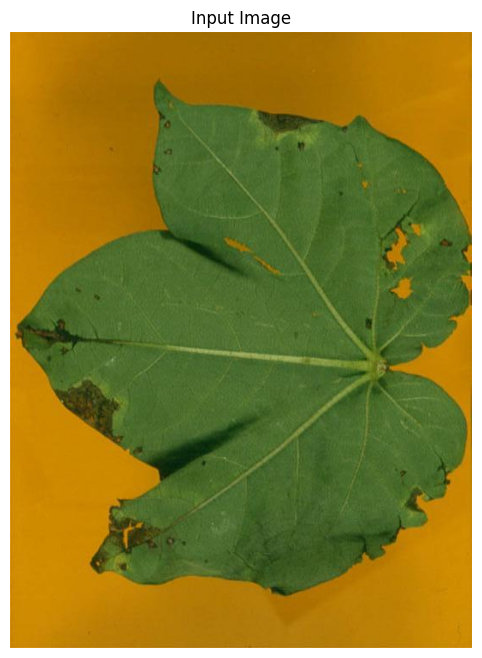


Prediction Results:
Predicted Disease: bacterial_blight
Confidence: 61.11%

Disease Parameters:
Strength Percentage: -20.0
Length: -10.0
Maturity Ratio: 0
Elongation: 0
Uniformity: -10.0
Micronaire Index: -5.0
Pressley Resistance: 0
Trash: 5.0
Production: -20.0
Fiber Percentage: -8.0
Ginning Percentage: -7.0
Colour Grade: 0
Weight of 100 Seeds: -4.0
Weight of 1 Boll: -3.0
Bolls Per Plant: -20.0

Description: Bacterial Blight, causing significant reductions in fiber quality and yield.



In [44]:
# Example usage
image_path = '/home/chemicalmyth/Cotton_Dataset/train/bacterial_blight/bact8.jpg'  # Replace with your image path
predict_and_display(model, image_path, device)